In [74]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from collections import Counter
import random

In [75]:
dataset_path = "animal_dataset"

class_counts = {}
class_to_image_paths = {}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        img_files = [
            os.path.join(class_path, f)
            for f in os.listdir(class_path)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]
        class_counts[class_name] = len(img_files)
        class_to_image_paths[class_name] = img_files

# Image Counts Per Class

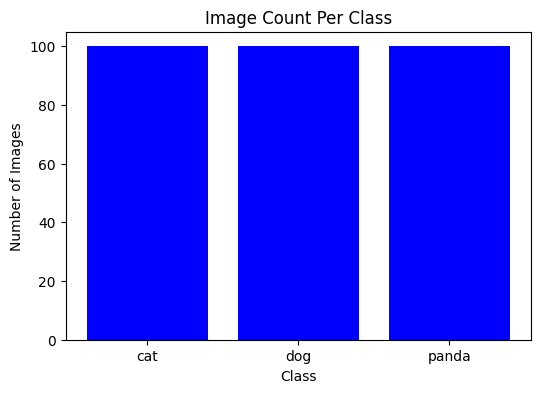

In [76]:
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(6,4))
plt.bar(classes, counts, color="blue")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Image Count Per Class")
plt.show()

# Sample Image Visualization Before Preprocessing

Sample images BEFORE preprocessing


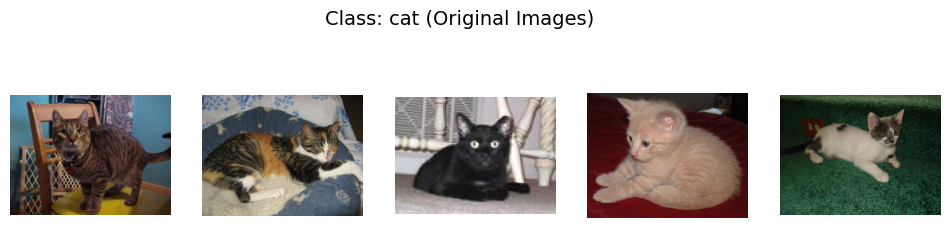

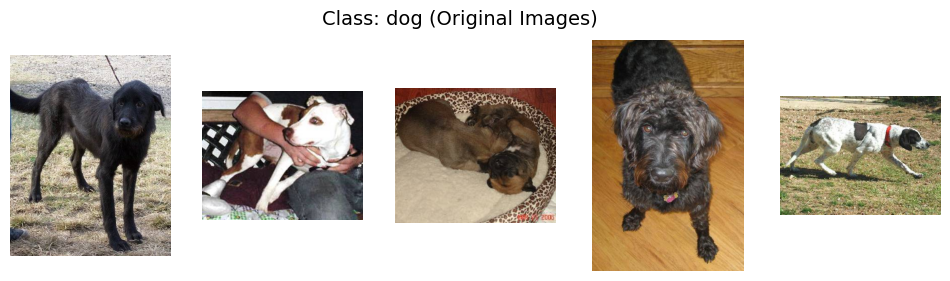

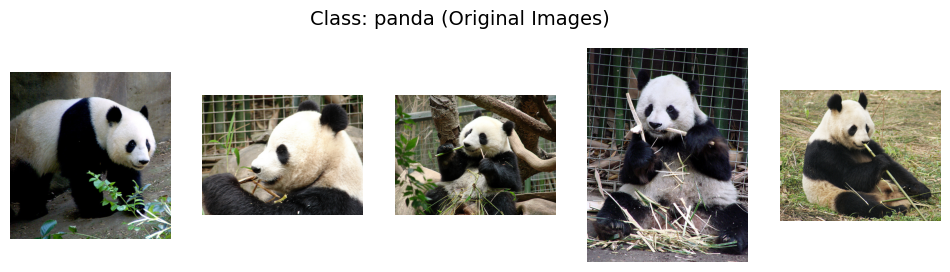

In [77]:
print("Sample images BEFORE preprocessing")

for cls, paths in class_to_image_paths.items():
    sample_paths = paths[:5]  

    plt.figure(figsize=(12, 3))
    for i, img_path in enumerate(sample_paths):
        img = Image.open(img_path)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(f"Class: {cls} (Original Images)", fontsize=14)
    plt.show()

# Preprocessing

In [78]:
def load_images(dataset_path, target_size=(32, 32)):
    images = []
    labels = []

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_file)

                    img = Image.open(img_path).convert("L")    
                    img = img.resize(target_size)             
                    img_array = np.array(img).flatten()        

                    images.append(img_array)
                    labels.append(class_name)

    return np.array(images), np.array(labels)

images, labels = load_images(dataset_path)
print(f"\nLoaded {len(images)} images")
print(f"Image vector shape: {images[0].shape}")
print(f"Classes found: {np.unique(labels)}")


Loaded 300 images
Image vector shape: (1024,)
Classes found: ['cat' 'dog' 'panda']


# Sample Image Visualization After Preprocessing

Sample images AFTER preprocessing


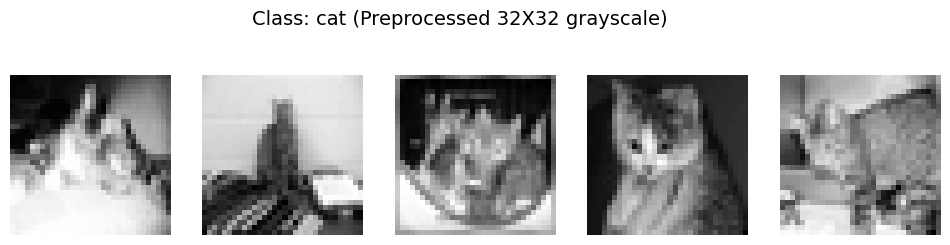

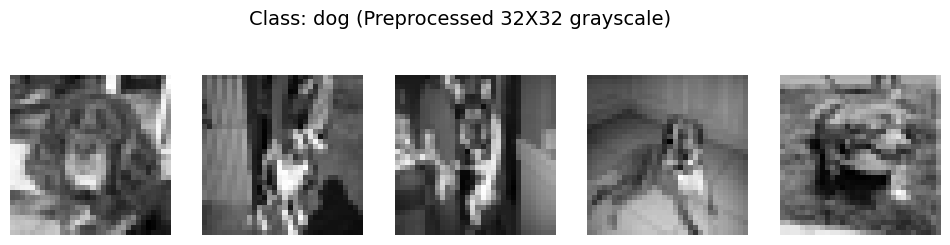

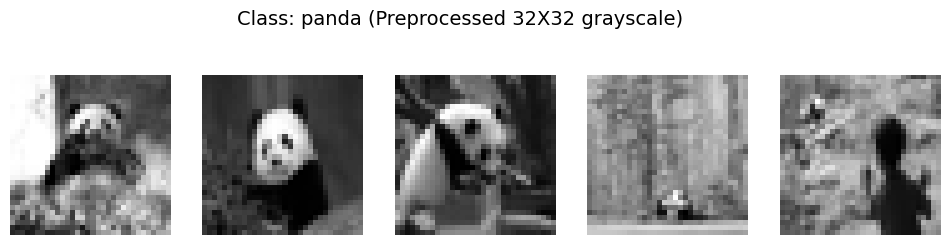

In [79]:
print("Sample images AFTER preprocessing")

img_size = (32, 32)
unique_classes = np.unique(labels)

for cls in unique_classes:
    class_indices = np.where(labels == cls)[0]
    sampled_idx = np.random.choice(class_indices, size=min(5, len(class_indices)), replace=False)

    plt.figure(figsize=(12, 3))

    for i, idx in enumerate(sampled_idx):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[idx].reshape(img_size), cmap="gray")
        plt.axis("off")

    plt.suptitle(f"Class: {cls} (Preprocessed 32X32 grayscale)", fontsize=14)
    plt.show()

# Distance Functions

In [80]:
def manhattan_distance(img1, img2):
    return np.sum(np.abs(img1 - img2))

def euclidean_distance(img1, img2):
    return np.sqrt(np.sum((img1 - img2) ** 2))

# KNN Function

In [81]:

def get_neighbors(training_imgs, training_labels, test_img, k, distance_func):

    distances = []

    for i in range(len(training_imgs)):
        dist = distance_func(test_img, training_imgs[i])
        distances.append((training_labels[i], dist))

    distances.sort(key=lambda x: x[1])

    neighbors = [distances[i][0] for i in range(k)]
    return neighbors

def predict(neighbors):
    counter = Counter(neighbors)
    return counter.most_common(1)[0][0]

# 5 Fold Cross-Validation

In [82]:
def create_folds(images, labels, k_folds=5):

    n = len(images)
    indices = list(range(n))
    np.random.shuffle(indices)

    fold_size = n // k_folds
    folds = []

    for i in range(k_folds):
        start = i * fold_size
        end = (i + 1) * fold_size if i < k_folds - 1 else n
        test_indices = indices[start:end]
        train_indices = indices[:start] + indices[end:]

        folds.append({
            'train_imgs': images[train_indices],
            'train_labels': labels[train_indices],
            'test_imgs': images[test_indices],
            'test_labels': labels[test_indices]
        })

    return folds

# Create folds
folds = create_folds(images, labels, k_folds=5)
print(f"Created {len(folds)} folds")
print(f"Training samples per fold: {len(folds[0]['train_imgs'])}")
print(f"Test samples per fold: {len(folds[0]['test_imgs'])}")

Created 5 folds
Training samples per fold: 240
Test samples per fold: 60


# Calculate Distance

In [83]:
def cross_validate(folds, k_values, distance_func, distance_name):

    results = {k: [] for k in k_values}

    for fold_idx, fold in enumerate(folds):
        print(f"Processing fold {fold_idx + 1} for {distance_name}...")

        train_imgs = fold['train_imgs']
        train_labels = fold['train_labels']
        test_imgs = fold['test_imgs']
        test_labels = fold['test_labels']

        for k in k_values:
            correct = 0
            total = len(test_imgs)

            for i in range(total):
                neighbors = get_neighbors(train_imgs, train_labels, test_imgs[i], k, distance_func)
                prediction = predict(neighbors)

                if prediction == test_labels[i]:
                    correct += 1

            accuracy = correct / total
            results[k].append(accuracy)

    avg_results = {k: np.mean(accuracies) for k, accuracies in results.items()}
    return avg_results


k_values = [1, 3, 5, 7, 9]

print("Calculating Manhattan (L1) distances...")
l1_results = cross_validate(folds, k_values, manhattan_distance, "Manhattan")

print("Calculating Euclidean (L2) distances...")
l2_results = cross_validate(folds, k_values, euclidean_distance, "Euclidean")

print("Cross-validation completed!")

Calculating Manhattan (L1) distances...
Processing fold 1 for Manhattan...
Processing fold 2 for Manhattan...
Processing fold 3 for Manhattan...
Processing fold 4 for Manhattan...
Processing fold 5 for Manhattan...
Calculating Euclidean (L2) distances...
Processing fold 1 for Euclidean...
Processing fold 2 for Euclidean...
Processing fold 3 for Euclidean...
Processing fold 4 for Euclidean...
Processing fold 5 for Euclidean...
Cross-validation completed!


# Accuracies 

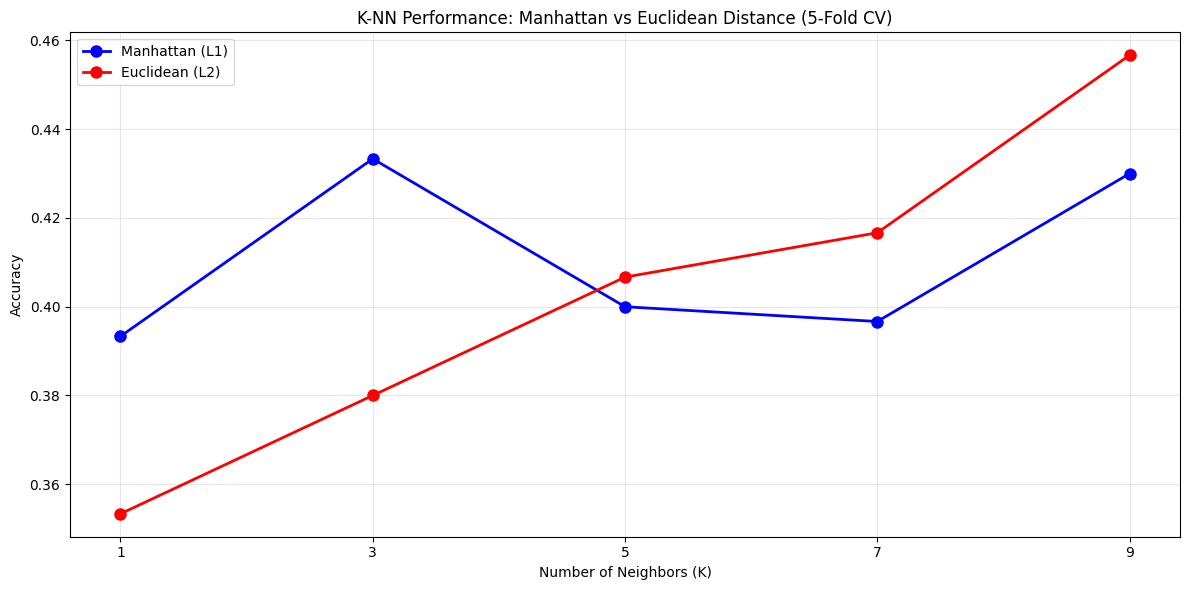

In [84]:
k_list = list(k_values)
l1_accuracies = [l1_results[k] for k in k_values]
l2_accuracies = [l2_results[k] for k in k_values]

plt.figure(figsize=(12, 6))
plt.plot(k_list, l1_accuracies, 'bo-', label='Manhattan (L1)', linewidth=2, markersize=8)
plt.plot(k_list, l2_accuracies, 'ro-', label='Euclidean (L2)', linewidth=2, markersize=8)

plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('K-NN Performance: Manhattan vs Euclidean Distance (5-Fold CV)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

plt.tight_layout()
plt.show()

# Best k-value and distance function

In [85]:
print("\nAverage Accuracy for Different K Values:")
print("K\tManhattan (L1)\tEuclidean (L2)")
print("-" * 40)
for k in k_values:
    print(f"{k}\t{l1_results[k]:.4f}\t\t{l2_results[k]:.4f}")

best_k_l1 = max(l1_results, key=l1_results.get)
best_k_l2 = max(l2_results, key=l2_results.get)

print(f"\nBest K for Manhattan: {best_k_l1} (Accuracy: {l1_results[best_k_l1]:.4f})")
print(f"Best K for Euclidean: {best_k_l2} (Accuracy: {l2_results[best_k_l2]:.4f})")

if l1_results[best_k_l1] > l2_results[best_k_l2]:
    print(f"\nBest Distance Function: Manhattan (L1)")
    best_distance = manhattan_distance
    best_k = best_k_l1
else:
    print(f"\nBest Distance Function: Euclidean (L2)")
    best_distance = euclidean_distance
    best_k = best_k_l2


Average Accuracy for Different K Values:
K	Manhattan (L1)	Euclidean (L2)
----------------------------------------
1	0.3933		0.3533
3	0.4333		0.3800
5	0.4000		0.4067
7	0.3967		0.4167
9	0.4300		0.4567

Best K for Manhattan: 3 (Accuracy: 0.4333)
Best K for Euclidean: 9 (Accuracy: 0.4567)

Best Distance Function: Euclidean (L2)


# Predict Best Images

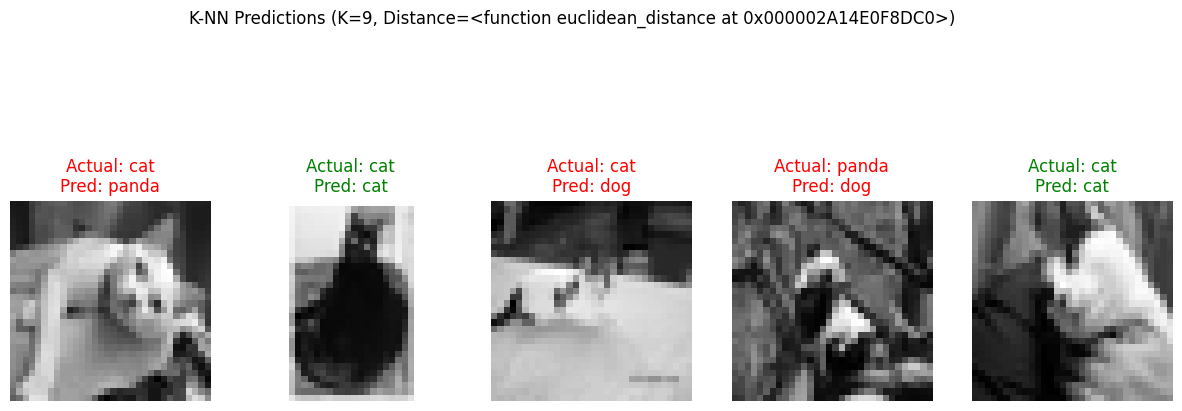

In [86]:
fold = folds[k_values.index(best_k)]
train_imgs = fold['train_imgs']
train_labels = fold['train_labels']
test_imgs = fold['test_imgs']
test_labels = fold['test_labels']

num_samples = 5
random_indices = random.sample(range(len(test_imgs)), num_samples)

predictions_data = []

for i in random_indices:
    test_image = test_imgs[i]
    actual_label = test_labels[i]

    neighbors = get_neighbors(train_imgs, train_labels, test_image, best_k, best_distance)
    predicted_label = predict(neighbors)

    is_correct = (predicted_label == actual_label)
    predictions_data.append({
        'test_index': i,
        'test_image': test_image,
        'actual_label': actual_label,
        'predicted_label': predicted_label,
        'neighbors': neighbors,
        'correct': is_correct
    })

plt.figure(figsize=(15, 6))
for i, pred_info in enumerate(predictions_data):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(pred_info['test_image'].reshape(img_size), cmap='gray')

    color = 'green' if pred_info['correct'] else 'red'

    title_text = f"Actual: {pred_info['actual_label']}\nPred: {pred_info['predicted_label']}"
    plt.title(title_text, color=color)
    plt.axis('off')

plt.suptitle(f'K-NN Predictions (K={best_k}, Distance={best_distance})')
plt.show()
     

## **Discussion**

1. Using 5-fold cross-validation, the Euclidean (L2) distance metric performed better than the Manhattan (L1) distance for this dataset.  
   The highest accuracy achieved was **45.67% at K = 9** using the Euclidean distance, whereas Manhattan distance reached a maximum accuracy of **43.33% at K = 3**.  
   This shows that L2 distance provides better discriminative ability for this feature space.

2. The dataset contains **3 animal classes**, and each image was preprocessed into a **32×32 grayscale vector**.  
   Although converting to grayscale reduces computational complexity, it removes color information that is often important for distinguishing animals such as cats, dogs, and pandas.  
   The low resolution and lack of color cause substantial **feature overlap**, making it difficult for K-NN to separate classes based solely on pixel intensity.

3. Euclidean (L2) distance performed better likely because the squared differences amplify stronger variations in pixel intensity patterns.  
   This helps L2 capture structural differences in the images more effectively than Manhattan distance, which treats all absolute differences equally.

---

## **Limitations**

The overall accuracy remains relatively low (below 50%).  
This indicates that **raw pixel intensities are weak features** for image classification, especially after flattening and removing RGB color channels.  
The very low image resolution (32×32) also results in loss of important spatial details.

---

## **Potential Improvements**

To improve classification performance, several strategies can be applied:

- **Use RGB images instead of grayscale** to preserve color cues.  
- **Increase image resolution** before flattening or feature extraction.  
- **Apply data augmentation** (rotations, flips, noise) to increase variability and reduce overfitting.  
- **Use feature extraction techniques** such as HOG, SIFT, or PCA for dimensionality reduction.  
- **Adopt deep learning approaches (e.g., CNNs)**, which are far more effective at learning spatial patterns in images compared to K-NN on raw pixels.

---
